In [ ]:
import sys
sys.path.append('/Users/kk/code/pyrobo/src//')

In [ ]:
import eLabPeersRobo


In [ ]:
robot = eLabPeersRobo.init_robo()

In [ ]:
robot.open_claw()

In [ ]:
robot.current_pos

In [ ]:
robot.fkine([0,0,0,0,0])[:,3]

### Robot pickup marker and drop in box demo

In [ ]:
import time

robot.open_claw()
robot.move_to((180,-15,-30))
time.sleep(3)
robot.close_claw()
robot.move_to((175,0,300))
robot.move_to((150,220,160))
robot.open_claw()
robot.move_to((175,0,300))


In [ ]:
robot.move_to((180,-15,-30))

In [ ]:
robot.move_to((50,-200,50))

### Robot camera

In [4]:
import urllib2
from operator import mul
import numpy as np


col_sz = (480, 640, 3)
dep_sz = (480, 640)
pnt_sz = (480, 640, 3)
cad_sz = (480, 640, 3)

col_dtype = np.uint8
dep_dtype = np.uint16
cad_dtype = np.uint8
pnt_dtype = np.float32



def from_buffer(im_str, sz, dtype_dat):
    f1 = np.fromstring(im_str, dtype=dtype_dat)
    return f1.reshape(sz)    

def get_images():
    response=urllib2.urlopen('http://robot.local:8888/camera')
    col = from_buffer(response.read(reduce(mul, col_sz)), col_sz, col_dtype)
    pnt = from_buffer(response.read(reduce(mul, pnt_sz)*4), pnt_sz, pnt_dtype)
    cad = from_buffer(response.read(reduce(mul, cad_sz)), cad_sz, cad_dtype)
    response.close()
    return col, pnt, cad


In [ ]:
%matplotlib notebook

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from matplotlib import pyplot as plt

class LineBuilder:
    def __init__(self, line):
        self.started = False
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.x_0 = None
        self.y_0 = None
        self.cidpress = self.line.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.line.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.line.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        
        
    def on_press(self, event):
        self.x_0 = event.xdata
        self.y_0 = event.ydata
        self.started = True
    
    def on_release(self, event):
        x_press, y_press = event.xdata, event.ydata
        self.started = False
        self.draw_box(event)
        
    def draw_box(self, event):
        self.x_press, self.y_press = event.xdata, event.ydata
        self.xs = [self.x_0, self.x_press, self.x_press, self.x_0, self.x_0]
        self.ys = [self.y_0, self.y_0, self.y_press, self.y_press, self.y_0]
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
    
    def on_motion(self, event):
        if not self.started:
            return
        if np.random.random() < 0.25:
            self.draw_box(event)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(col)
ax.set_title('click to mark bounding box')
line, = ax.plot([0], [0])  # empty line
linebuilder = LineBuilder(line)
plt.show()

In [ ]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [ ]:
xlims = (30, 330)
ylims = ( -200, 250)
zlims = (50, 300)
maxd = 100000

def valid_random_position():
    valid = False
    while not valid:
        x = np.random.randint(xlims[0], xlims[1])
        y = np.random.randint(ylims[0], ylims[1])
        z = np.random.randint(zlims[0], zlims[1])
        if x*x + y*y + z*z < maxd:
            valid = True
    return (x,y,z)

In [ ]:
import urllib2

import tensorflow as tf
example = tf.train.Example()

filename = '/data/robotics/raw_position_images/train_3' + '.tfrecords'
writer = tf.python_io.TFRecordWriter(filename)

def take_photo(label):
    iminfo = urllib2.urlopen('http://robot.local:8888/camera').read()
    example_out = tf.train.Example(features=tf.train.Features(feature={
                'label': _bytes_feature(label),
                'iminfo': _bytes_feature(iminfo)}))
    writer.write(example_out.SerializeToString())


In [ ]:
writer.close()

In [ ]:
import tensorflow as tf
import time

example = tf.train.Example()
filename = '/data/robotics/raw_position_images/train_3' + '.tfrecords'
writer = tf.python_io.TFRecordWriter(filename)


for j in range(10):
    robot = eLabPeersRobo.init_robo()

    for i in range(50):
        pos = valid_random_position()
        try:
            robot.move_to(pos)
        except:
            robot = eLabPeersRobo.init_robo()
        motor_pos = robot.current_pos
        time.sleep(1)
        iminfo = urllib2.urlopen('http://robot.local:8888/camera').read()
        example_out = tf.train.Example(features=tf.train.Features(feature={
                'x_y_pos': _float_feature(pos),
                 'motor_pos': _float_feature(motor_pos),
                'iminfo': _bytes_feature(iminfo)}))
        writer.write(example_out.SerializeToString())
        robot.move_to((175,0,300))
        print len(iminfo), len(pos), len(motor_pos)

writer.close()        


#### Integration with detector

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

In [2]:
import requests
import cv2
import numpy as np
import cPickle

def get_class_box_prob(im):
    success, encimg = cv2.imencode('.jpg', im)
    r = requests.post("http://lhdppn01p36:18057/detect/img", data={'data':encimg.tostring()})
    dat = cPickle.loads(r.content)
    return dat
    

def translate_to_robot(prediction_array, camera_pos):
    return np.dot(prediction_array, np.hstack([camera_pos, [1]]))

pa = np.load('/data/models/camera_to_robot_pos_map/camera_robot_translation_matrix.npy')

import time
def pickup_drop(r):
    robot.open_claw()
    robot.move_to((int(r[0]),int(r[1]),-50))
    time.sleep(3)
    robot.close_claw()
    robot.move_to((175,0,300))
    robot.move_to((150,220,160))
    robot.open_claw()
    robot.move_to((175,0,300))


In [43]:
col, pnt, cad = get_images()

r = get_class_box_prob(col)

bbox = r['arm']['arm'][0][:4]

In [40]:
office_supplies = r['office_supplies']
(obj, metr) = sorted(office_supplies.items(), key=lambda (obj, metr): -metr[0,4])[0]
metr=  office_supplies['pen']
bbox = metr[0,:4]

In [44]:
from scipy.linalg import norm

arm = col[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]), :]
x_offset = 40
y_offset = 10


result = []
for i in range(-5,5):
    for j in range(-5,5):
        y_offset_new = y_offset + i
        x_offset_new = x_offset + j
        cadarm = cad[y_offset_new + int(bbox[1]):y_offset_new + int(bbox[3]),
                     x_offset_new+int(bbox[0]):x_offset_new+int(bbox[2]), :]
        mask = cadarm > 0
        mask = mask.astype(np.uint8)
        masked_arm = arm*mask
        result.append((i, j, norm(masked_arm - cadarm)))

y_err, x_err, scr =  sorted(result, key=lambda x: x[-1])[0]

x_offset = 40+x_err
y_offset = 10+y_err
y_strt = y_offset + int(bbox[1])
y_end = y_offset + int(bbox[3])
x_strt = x_offset+int(bbox[0])
x_end = x_offset+int(bbox[2])
cadarm = cad[y_strt:y_end, x_strt:x_end, :]
pntarm = pnt[y_strt:y_end, x_strt:x_end, :]

wid,hei,colr = pntarm.shape
pntarm_flat = pntarm.reshape((wid*hei, colr))

nonzero = pntarm_flat[np.where((norm(pntarm_flat, axis=1)>0) & (pntarm_flat[:,2]<1)),]

(x,y,z) = nonzero[0,...].mean(axis=0)


x,y,z

(0.2108321, -0.10249985, 0.69181794)

In [39]:
office_supplies

{'box': array([[  1.55794067e+02,   3.94167847e+02,   4.14265686e+02,
           4.78411621e+02,   1.80246726e-01],
        [  2.48147659e+02,   3.03348969e+02,   3.91526245e+02,
           3.67072784e+02,   1.09470516e-01],
        [  1.07639076e+02,   2.39955887e+02,   2.04645020e+02,
           3.04968658e+02,   5.23826890e-02],
        [  1.14103775e+01,   7.72472992e+01,   1.76213593e+02,
           2.04249924e+02,   3.34831662e-02],
        [  0.00000000e+00,   2.48734909e+02,   1.43129456e+02,
           4.64652222e+02,   8.46768450e-03],
        [  3.50787628e+02,   2.23584854e+02,   4.39598724e+02,
           2.84508392e+02,   6.53068675e-03],
        [  4.44130341e+02,   3.87125702e+02,   6.39000000e+02,
           4.73231171e+02,   3.71161313e-03],
        [  3.22184753e+02,   1.10465668e+02,   5.79858459e+02,
           4.21014313e+02,   2.06109555e-03],
        [  2.59796448e+02,   3.55394531e+02,   3.36450562e+02,
           4.14093689e+02,   1.64262147e-03],
        [  1

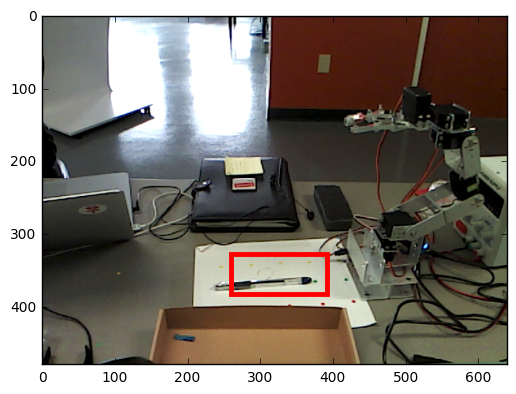

In [41]:

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(col)
ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )


In [42]:
arm_relative_camera = (0.063879602, 0.16049324, 0.72108197)
ymid = int((bbox[0] + bbox[2])/2)
xmid = int((bbox[1] + bbox[3])/2)
xmid, ymid

pnt[xmid, ymid]


array([ 0.00831043,  0.14559391,  0.74300003], dtype=float32)

In [8]:
col, pnt, cad = get_images()

cls, bbox = sorted(get_class_box_prob(col), key=lambda (cls, arr):-arr[-1])[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(col)
ax.add_patch(\
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
print cls

ymid = int((bbox[0] + bbox[2])/2)
xmid = int((bbox[1] + bbox[3])/2)
xmid, ymid

r = translate_to_robot(pa, pnt[xmid, ymid])
while r.sum() == 0:
    xshft, yshft = np.random.randint(-10, 10, 2)
    r = translate_to_robot(pa, pnt[xmid + xshft, ymid+yshft])
r[0]-=50

ValueError: too many values to unpack

In [45]:
r, translate_to_robot(pa, pnt[364, 295])

({'arm': {'arm': array([[  3.95307739e+02,   1.19999580e+02,   4.83747131e+02,
             1.67674210e+02,   9.49202538e-01],
          [  4.64864105e+02,   3.90023193e+02,   5.10477020e+02,
             4.79000000e+02,   1.94952328e-04],
          [  4.85370972e+02,   1.17858360e+02,   5.21239502e+02,
             1.61986938e+02,   1.56412498e-04],
          [  5.11343811e+02,   3.92595703e+02,   5.66198303e+02,
             4.77938477e+02,   1.20713041e-04],
          [  1.50005249e+02,   3.99939484e+02,   3.39123596e+02,
             4.79000000e+02,   7.31550099e-05],
          [  5.78289429e+02,   7.45408936e+01,   6.37807861e+02,
             1.92733521e+02,   4.02072983e-05],
          [  5.79614197e+02,   4.19985657e+02,   6.37675842e+02,
             4.79000000e+02,   3.15721081e-05],
          [  1.00033035e+01,   2.45539764e+02,   1.20275108e+02,
             4.67261322e+02,   2.89913114e-05],
          [  5.60545593e+02,   2.68697144e+02,   6.37167542e+02,
             3.75

In [ ]:
ymid = int((bbox[0] + bbox[2])/2)
xmid = int((bbox[1] + bbox[3])/2)
xmid, ymid

In [ ]:
r = translate_to_robot(pa, pnt[xmid, ymid])
while r.sum() == 0:
    xshft, yshft = np.random.randint(0, 15, 2)
    translate_to_robot(pa, pnt[xmid + xshft, ymid+yshft])


In [ ]:
translate_to_robot(pa, pnt[359, 379])

In [ ]:
pickup_drop(r)

In [ ]:

midx = xr[0]

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cad)
ax.add_patch(
            plt.Rectangle((40+bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )

In [ ]:
loc = pnt[40+int(bbox[0]):40+int(bbox[2]), int(bbox[1]):int(bbox[3]),:]

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
%matplotlib notebook

In [ ]:
# col, pnt, cad = get_images()

plt.imshow(cad)

In [ ]:
ipmatr = np.asarray([[334, 295 , 250, -55, 0],
[331, 334 , 200, -55, 0],
[328, 371 , 150, -55, 0],
[326, 409 , 100, -55, 0],
[324, 444 , 50., -55., 0],
[360, 297 , 250, -5, 0],
[358, 339 , 200, -5, 0],
[357, 378 , 150, -5, 0],
[352, 419 , 100, -5, 0],
[350, 458 , 50, -5, 0],
[390, 303 , 250, 45, 0],
[386, 347 , 200, 45, 0],
[383, 388 , 150, 45, 0],
[382, 432 , 100, 45, 0],
[379, 471 , 50, 45, 0]])

In [ ]:
camera_perspect = []
for i in range(ipmatr.shape[0]):
    x,y = ipmatr[i,:2]
    camera_pos = pnt[int(x),int(y)]
    camera_perspect.append(camera_pos)
cp = np.array(camera_perspect)    

In [ ]:
from sklearn import linear_model

linX = linear_model.LinearRegression()
modX = linX.fit(cp, ipmatr[:, 2])
linY = linear_model.LinearRegression()
modY = linY.fit(cp, ipmatr[:, 3])
linZ = linear_model.LinearRegression()
modZ = linZ.fit(cp, ipmatr[:, 4])



In [ ]:
prediction_array = np.vstack([np.hstack([modX.coef_, modX.intercept_]),
np.hstack([modY.coef_, modY.intercept_]),
np.hstack([modZ.coef_, modZ.intercept_])])

array([[ -974.53560927,   122.36421544,   -67.95457513,   257.34227589],
       [   95.99883131,  1152.97642791,  -428.39023665,   138.17721252],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

In [ ]:
np.save('/data/models/camera_to_robot_pos_map/camera_robot_translation_matrix', prediction_array)

In [ ]:
translate_to_robot(pa, pnt[235,235])